In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import scipy.optimize as sco
import scipy.interpolate as itp

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
symbols = ['APTS', 'SSD', 'CACC']#, 'CHGG', 'APTI', 'MEDP', 'STRL', 'EXAC', 'TREX', 'OFIX']
noa = len(symbols)

In [4]:
from datetime import datetime, timedelta
N = 200
days_ago_N = datetime.now() - timedelta(days=N)
days_ago_N_string = days_ago_N.strftime('%Y-%m-%d')

In [5]:
%%time
df = pd.DataFrame()
start = days_ago_N_string
for symbol in symbols:
    print(symbol)
    df[symbol] = data.DataReader(symbol, 'yahoo', start)['Close']

APTS
SSD
CACC
Wall time: 3.59 s


In [6]:
df.head()

,APTS,SSD,CACC
Date,,,
2017-04-12,13.82,41.259998,193.690002
2017-04-13,13.66,40.820000,192.559998
2017-04-17,13.71,41.450001,194.130005
2017-04-18,14.36,41.070000,195.970001
2017-04-19,14.33,41.540001,197.419998


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


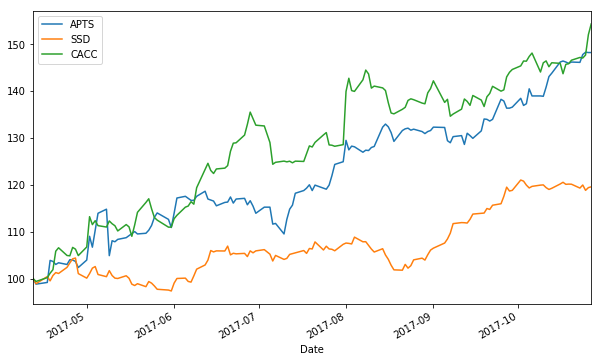

In [7]:
(df / df.ix[0] * 100).plot(figsize=(10,6))

In [8]:
rets = np.log(df / df.shift(1))

In [9]:
rets.mean() * 252

APTS    0.719150
SSD     0.326950
CACC    0.792859
dtype: float64

In [10]:
rets.cov() * 252

,APTS,SSD,CACC
APTS,0.058458,0.000184,0.009537
SSD,0.000184,0.019062,0.007150
CACC,0.009537,0.007150,0.059754


In [11]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.42735627,  0.17688967,  0.39575406])

In [12]:
np.dot(weights.T, rets.mean()) * 252

0.67894445271884385

In [13]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.024886307318681161

In [14]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.15775394549323057

In [15]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights = weights / np.sum(weights)
    prets.append(np.dot(weights.T, rets.mean() * 252))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

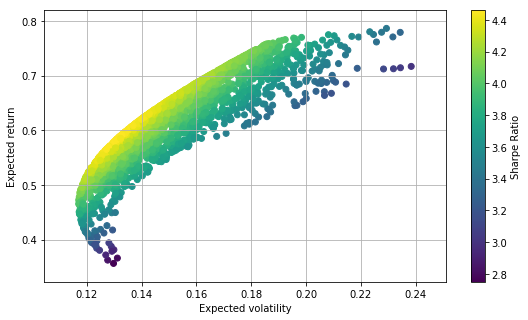

In [16]:
plt.figure(figsize=(9, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe Ratio')

In [17]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.dot(weights.T, rets.mean() * 252)
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [18]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [19]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

In [20]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

Wall time: 23 ms


In [21]:
opts

     fun: -4.461948189267195
     jac: array([-0.00236267, -0.00093508,  0.00375724])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.31346549,  0.3923075 ,  0.29422701])

In [22]:
def calc_weights(BP, xs, df):
    t = BP / np.dot(df.tail(1), xs)
    out = zip(symbols, t * xs)
    out = sorted(out, key=lambda tup: tup[1], reverse=True)
    return out

In [23]:
out = calc_weights(450.00, opts.x, df)
print out
print [sym[0] for sym in out if sym[1] > 0.00001]

[('SSD', 1.5518880679677445), ('APTS', 1.2400052013728462), ('CACC', 1.1639017403793925)]
['SSD', 'APTS', 'CACC']


In [24]:
df.tail(1)

,APTS,SSD,CACC
Date,,,
2017-10-27,20.49,49.349998,299.0
